In [1]:
import glob
import re
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import cv2
import numpy as np
import pandas as pd
import pydicom as dicom
from keras import Model, Input
from keras.src import backend
from keras.src import layers
from keras.src.applications import imagenet_utils
from keras.src.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.applications.densenet import DenseNet201
from keras.src.callbacks import Callback
import gc
from tensorflow.keras import backend as K
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import clip_ops, math_ops
from scipy.ndimage import gaussian_filter, rotate, zoom
import albumentations as A

2024-07-01 16:05:12.751236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 16:05:13.535397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
base_path = '/home/toru/PycharmProjects/rsna-2024-lumbar-spine-degenerative-classification'
train_png_file_path = f'{base_path}/train_dataset_png'

label_coordinates_df = pd.read_csv(f'{base_path}/train_label_coordinates.csv')
train_series = pd.read_csv(f'{base_path}/train_series_descriptions.csv')
df_train = pd.read_csv(f'{base_path}/train.csv')
df_sub = pd.read_csv(f'{base_path}/sample_submission.csv')
test_series = pd.read_csv(f'{base_path}/test_series_descriptions.csv')

train_dicom = f'{base_path}/train_images'
test_dicom = f'{base_path}/test_images'

model_path = f'model.keras'

In [3]:
# 一つのstudy_idにseries_id が3つ未満のstudy_idを探す
study_id_list = train_series['study_id'].unique()
for study_id in study_id_list:
    series_id_list = train_series[train_series['study_id'] == study_id][
        'series_description'].unique()

    if len(series_id_list) < 3:
        print(f'study_id : {study_id}, series_id : {series_id_list}')

study_id : 2492114990, series_id : ['Axial T2' 'Sagittal T2/STIR']
study_id : 2780132468, series_id : ['Sagittal T2/STIR' 'Axial T2']
study_id : 3008676218, series_id : ['Sagittal T1' 'Axial T2']


In [4]:
# パラメータ
STUDY_NUM = 1975

# 出力のラベル
NORMAL_MILD = 0
MODERATE = 1
SEVERE = 2

# 重症度一覧
SEVERITY_LIST = ['Normal/Mild', 'Moderate', 'Severe']

# dicomデータの種類
SERIES_DESCRIPTION_LIST = train_series['series_description'].unique().tolist()
# 学習用パラメータ
BATCH_SIZE = 1
EPOCHS = 1000
PATIENCE = 5 # 早期終了のパラメータ
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1
Lr = 1e-5 * (1.0 / BATCH_SIZE)

# 入出力の形状 (DenseNet201の入力サイズ)
INPUT_WIDTH = 512
INPUT_HEIGHT = 512
INPUT_CHANNEL_DICT = {
    'Sagittal T1': 17,
    'Sagittal T2/STIR': 17,
    'Axial T2': 29
}
IN_CHANS = sum(INPUT_CHANNEL_DICT.values())
IMG_SIZE = [INPUT_WIDTH, INPUT_HEIGHT]

CONDITIONS = [
    'spinal_canal_stenosis',
    'left_neural_foraminal_narrowing',
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

N_LABELS = 25
N_CLASSES = 3 * N_LABELS

data_filenames = ['train_data', 'valid_data', 'test_data']  # パラメータ

In [5]:
_target_name = "right_subarticular_stenosis_l5_s1"

print(f'train shape : {df_train.shape}')
print(df_train[_target_name].unique())

# それぞれの重症度の数がいくらあるか計算
print(f'Normal/Mild : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0]}')
print(f'Moderate : {df_train[df_train[_target_name] == str("Moderate")].shape[0]}')
print(f'Severe : {df_train[df_train[_target_name] == str("Severe")].shape[0]}')

print(
    f'Normal/Mild ratio : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0] / df_train.shape[0]}')
print(
    f'Moderate ratio : {df_train[df_train[_target_name] == str("Moderate")].shape[0] / df_train.shape[0]}')
print(
    f'Severe ratio : {df_train[df_train[_target_name] == str("Severe")].shape[0] / df_train.shape[0]}')


train shape : (1975, 26)
['Normal/Mild' 'Moderate' 'Severe' nan]
Normal/Mild : 1399
Moderate : 396
Severe : 173
Normal/Mild ratio : 0.7083544303797469
Moderate ratio : 0.20050632911392405
Severe ratio : 0.08759493670886076


In [6]:


def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]


def get_train_label(study_id):
    """
    study_id に対応するラベルを取得 (testはデータがないのでtrainのみ)
    """

    row = df_train[df_train['study_id'] == study_id].to_numpy()[0][1:].tolist()

    row_category = np.zeros((N_LABELS, 3))
    for i in range(N_LABELS):
        if row[i] == 'Normal/Mild':
            row_category[i][0] = 1
        elif row[i] == 'Moderate':
            row_category[i][1] = 1
        elif row[i] == 'Severe':
            row_category[i][2] = 1
    # 1次元配列に変換
    row_category = row_category.flatten()
    return row_category


def get_file_list(study_id, series_desc, file_kind='train'):
    """
    study_id に対応するファイルリストを取得
    """
    dicom_file_list = []
    df = None
    if file_kind == 'train':
        df = train_series
    elif file_kind == 'test':
        df = test_series

    # study_id に対応する series_desc のリストを取得
    series_ids = df[df['study_id'] == study_id]
    series_id = series_ids[series_ids['series_description'] == series_desc]['series_id'].values
    if len(series_id) == 0:
        return dicom_file_list

    series_id = series_id[0]

    target_dicom_dir_path = ''
    if file_kind == 'train':
        target_dicom_dir_path = f'{train_dicom}/{study_id}/{series_id}/'
    elif file_kind == 'test':
        target_dicom_dir_path = f'{test_dicom}/{study_id}/{series_id}/'
    dicom_file_list = glob(target_dicom_dir_path + '/*.dcm')
    # ファイル名が数字になっているのでソート
    dicom_file_list = sorted(dicom_file_list, key=natural_keys)

    # series_desc にt対応するファイルリストを取得
    return dicom_file_list


def load_dicom_img(dicom_filepath):
    """
    dicomファイルを読み込む
    """
    dicom_data = dicom.read_file(dicom_filepath).pixel_array

    # 0-1に正規化
    dicom_data = dicom_data / np.max(dicom_data)

    # 0~255に変換
    dicom_data = dicom_data * 255

    # 512x512にリサイズ
    dicom_data = cv2.resize(dicom_data, (INPUT_WIDTH, INPUT_HEIGHT))

    # uint8 に変換
    dicom_data = dicom_data.astype(np.uint8)

    return dicom_data


def get_dicom_input_data(study_id, file_kind='train'):
    """
    study_id に対応するdicomデータを取得
    """

    input_dicom = np.zeros((INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS))
    # Sagittal T1
    sagittal_t1_dicom_list = get_file_list(study_id, 'Sagittal T1', file_kind)
    if len(sagittal_t1_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T1']):
            if i < len(sagittal_t1_dicom_list):
                dicom_data = load_dicom_img(sagittal_t1_dicom_list[i])
                input_dicom[:, :, i] = dicom_data

    # Sagittal T2/STIR
    sagittal_t2_dicom_list = get_file_list(study_id, 'Sagittal T2/STIR', file_kind)
    if len(sagittal_t2_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T2/STIR']):
            if i < len(sagittal_t2_dicom_list):
                dicom_data = load_dicom_img(sagittal_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1']] = dicom_data

    # Axial T2
    axial_t2_dicom_list = get_file_list(study_id, 'Axial T2', file_kind)
    if len(axial_t2_dicom_list) > 0:
        for i in range(INPUT_CHANNEL_DICT['Axial T2']):
            if i < len(axial_t2_dicom_list):
                dicom_data = load_dicom_img(axial_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1'] + INPUT_CHANNEL_DICT[
                    'Sagittal T2/STIR']] = dicom_data

    # uint8 に変換
    input_dicom = input_dicom.astype(np.int8)
    return input_dicom


def get_dicom_and_label(study_id, file_kind):
    x_data = get_dicom_input_data(study_id, file_kind)
    y_data = get_train_label(study_id)
    return x_data, y_data


def generator(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    データセットの読み込み関数
    """
    while True:
        if is_shuffle:
            np.random.shuffle(study_ids)

        for start in range(0, len(study_ids), batch_size):
            gc.collect()

            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(study_ids))
            ids_train_batch = study_ids[start:end]

            with ThreadPoolExecutor() as executor:
                results = list(
                    executor.map(lambda sid: get_dicom_and_label(sid, file_kind), ids_train_batch))

            for x_data, y_data in results:
                if is_augmentation:
                    # 画像データにノイズを加える
                    x_data = x_data + np.random.normal(0, 0.1, x_data.shape)

                x_batch.append(x_data)
                y_batch.append(y_data)

            yield np.array(x_batch), np.array(y_batch)


def generator_load_all(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    実行時予めすべてのデータを読み込んだ上でデータを返す
    """
    x_batch = []
    y_batch = []
    print(f'事前にすべてのデータを読み込みます')

    with ThreadPoolExecutor() as executor:
        results = list(
            executor.map(lambda sid: get_dicom_and_label(sid, file_kind), study_ids))

    for x_data, y_data in results:
        x_batch.append(x_data)
        y_batch.append(y_data)

    print(f'データの読み込みが完了しました')
    # データをバッチサイズに分割して返す
    while True:
        for start in range(0, len(x_batch), batch_size):
            end = min(start + batch_size, len(study_ids))

            x_batch_batch = x_batch[start:end]
            y_batch_batch = y_batch[start:end]

            if is_augmentation:
                for i in range(len(x_batch_batch)):
                    # ノイズを加える
                    x_batch_batch[i] = x_batch_batch[i] + np.random.normal(0, 0.1, x_batch_batch[i].shape)

            yield np.array(x_batch_batch), np.array(y_batch_batch)


def generate_and_save_data(study_ids, file_name, file_kind='train'):
    """
    学習用データを生成して保存
    """
    x_batch = []
    y_batch = []
    for sid in study_ids:
        print(f'残りのデータ数 : {len(study_ids) - len(x_batch)}')
        x_data, y_data = get_dicom_and_label(sid, file_kind)
        x_batch.append(x_data)
        y_batch.append(y_data)

    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)

    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')

    np.save(f'{file_name}_x.npy', x_batch)
    np.save(f'{file_name}_y.npy', y_batch)

    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()


def save_train_data():
    """
    学習用データを保存
    """
    train_study_ids = get_train_study_id_array()
    generate_and_save_data(train_study_ids, file_name='train_data', file_kind='train')


def save_valid_data():
    """
    検証用データを保存
    """
    valid_study_ids = get_valid_study_id_array()
    generate_and_save_data(valid_study_ids, file_name='valid_data', file_kind='train')


def save_test_data():
    """
    テスト用データを保存
    """
    test_study_ids = get_test_study_id_array()
    generate_and_save_data(test_study_ids, file_name='test_data', file_kind='train')


# 学習用データの study_id を取得
def get_train_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    train_study_ids = _study_ids[:int(len(_study_ids) * 0.8)]
    return train_study_ids


# 検証用データの study_id を取得
def get_valid_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    valid_study_ids = _study_ids[int(len(_study_ids) * 0.8):int(len(_study_ids) * 0.9)]
    return valid_study_ids


# テスト用データの study_id を取得 (実際のテストデータではなく, 学習データの一部をテストデータとして使用)
def get_test_study_id_array():
    _study_ids = train_series['study_id'].unique()
    # 0.8 で分割
    test_study_ids = _study_ids[int(len(_study_ids) * 0.9):]
    return test_study_ids


def generator_for_test(batch_size, study_ids):
    """
    test_seriesからテスト用のデータセット作成
    kaggle で提出時に呼び出される
    :param batch_size: 
    :param study_ids: 
    :return: 
    """
    for start in range(0, len(study_ids), batch_size):
        x_batch = []
        end = min(start + batch_size, len(study_ids))
        ids_train_batch = study_ids[start:end]

        for sid in ids_train_batch:
            dicom_img = get_dicom_input_data(sid, 'test')

            x_batch.append(dicom_img)


        yield np.array(x_batch), ids_train_batch


def generate_and_save_data(study_ids, file_name, file_kind='train'):
    """
    学習用データを生成して保存
    """
    x_batch = []
    y_batch = []
    for sid in study_ids:
        print(f'残りのデータ数 : {len(study_ids) - len(x_batch)}')
        x_data, y_data = get_dicom_and_label(sid, file_kind)
        x_batch.append(x_data)
        y_batch.append(y_data)

    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)

    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')

    np.save(f'{file_name}_x.npy', x_batch)
    np.save(f'{file_name}_y.npy', y_batch)

    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()


def load_data(file_name):
    """
    データを読み込む
    """
    x_data = np.load(f'{file_name}_x.npy')
    y_data = np.load(f'{file_name}_y.npy')

    return x_data, y_data


def generator_with_load_data(batch_size,
                             study_ids,
                             file_name,
                             file_kind='train',
                             is_augmentation=False,
                             is_shuffle=False,
                             is_only_one_epoch=False):
    """
    事前にデータを読み込んでデータを返す
    """
    x_batch, y_batch = load_data(file_name)

    def shuffle_data_and_labels(x_batch, y_batch):
        # データとラベルをペアにしたリストを作成
        data_label_pairs = list(zip(x_batch, y_batch))

        # ペアのリストをシャッフル
        np.random.shuffle(data_label_pairs)

        # シャッフル後のデータとラベルをそれぞれ別々の配列に戻す
        shuffled_x_batch, shuffled_y_batch = zip(*data_label_pairs)

        # NumPy 配列に変換して返す（オプション）
        shuffled_x_batch = np.array(shuffled_x_batch)
        shuffled_y_batch = np.array(shuffled_y_batch)

        return shuffled_x_batch, shuffled_y_batch

    while True:
        # epochごとにシャッフル
        if is_shuffle:
            x_batch, y_batch = shuffle_data_and_labels(x_batch, y_batch)

        for start in range(0, len(x_batch), batch_size):
            end = min(start + batch_size, len(study_ids))

            x_batch_batch = x_batch[start:end]
            y_batch_batch = y_batch[start:end]

            if is_augmentation:

                # 画像を正規化. (-があるので, offstetを加える)
                x_batch_batch = x_batch_batch.astype(np.float32)
                if np.min(x_batch_batch) < 0:
                    x_batch_batch = x_batch_batch + np.abs(np.min(x_batch_batch))
                x_batch_batch = x_batch_batch / (np.max(x_batch_batch) + 1e-6)

                for i in range(len(x_batch_batch)):
                    # ノイズを加える
                    x_batch_batch[i] = x_batch_batch[i] + np.random.normal(0, 0.1, x_batch_batch[i].shape)
                    
                    # 画像をぼかす
                    # ランダムなシグマ値を生成（例：-2.0から2.0の範囲）
                    sigma = np.random.uniform(-1.0, 1.0)
                    # シグマ値の絶対値を取ってガウシアンブラーを適用
                    x_batch_batch[i] = gaussian_filter(x_batch_batch[i], sigma=np.abs(sigma))

                    # 特定の範囲を切り抜く (10 ~ 50)
                    n_cut = np.random.randint(1, 5)
                    for _ in range(n_cut):
                        WINDOW_SIZE = np.random.randint(10, 100)
                        x_min = np.random.randint(0, x_batch_batch[i].shape[0] - WINDOW_SIZE)
                        x_max = x_min + WINDOW_SIZE
                        y_min = np.random.randint(0, x_batch_batch[i].shape[1] - WINDOW_SIZE)
                        y_max = y_min + WINDOW_SIZE
                        x_batch_batch[i][x_min:x_max, y_min:y_max, :] = 0
        
                    # 画像を上下, 左右にずらす
                    x_batch_batch[i] = np.roll(x_batch_batch[i], np.random.randint(-10, 10), axis=0)
                    x_batch_batch[i] = np.roll(x_batch_batch[i], np.random.randint(-10, 10), axis=1)

            # 画像を正規化. (-があるので, offstetを加える)
            x_batch_batch = x_batch_batch.astype(np.float32)
            if np.min(x_batch_batch) < 0:
                x_batch_batch = x_batch_batch + np.abs(np.min(x_batch_batch))
            x_batch_batch = x_batch_batch / (np.max(x_batch_batch) + 1e-6)

            # (0, 255) に変換
            x_batch_batch = x_batch_batch * 255

            # uint8 に変換
            x_batch_batch = x_batch_batch.astype(np.uint8)
            
            yield np.array(x_batch_batch), np.array(y_batch_batch)

        if is_only_one_epoch:
            break

    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()

x_batch shape : (1, 512, 512, 63)
study_ids : [44036939]


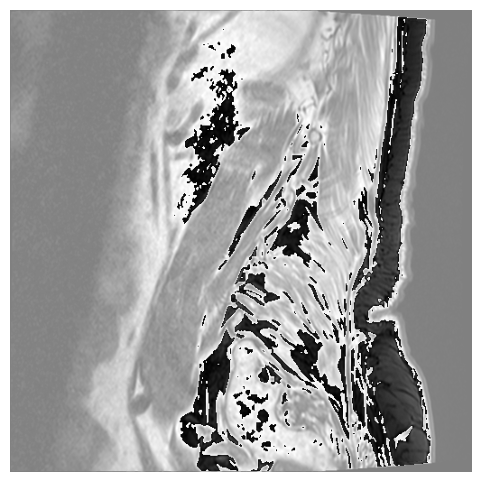

In [7]:
# generator_for_test を使ってテストデータを読み込む
test_dataset_ids = test_series['study_id'].unique()
for x_batch, study_ids in generator_for_test(BATCH_SIZE, test_dataset_ids):
    print(f'x_batch shape : {x_batch.shape}')
    print(f'study_ids : {study_ids}')

    # 画像を表示
    plt.figure(figsize=(6, 6))
    for i in range(1):
        plt.imshow(x_batch[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()
    break

In [8]:
# 2492114990
for desc in SERIES_DESCRIPTION_LIST:
    dicom_image_list = get_file_list(2492114990, desc)
    print(f'{desc} : {len(dicom_image_list)}')

Sagittal T2/STIR : 18
Sagittal T1 : 0
Axial T2 : 53


In [9]:
# study_id のリストを作成
train_study_ids = get_train_study_id_array()
print(len(train_study_ids))
valid_study_ids = get_valid_study_id_array()
print(len(valid_study_ids))
test_study_ids = get_test_study_id_array()
print(len(test_study_ids))

1580
197
198


x_batch shape : (1, 512, 512, 63)
y_batch shape : (1, 75)
x_batch max : 254
x_batch min : 0
x_batch dtype : uint8


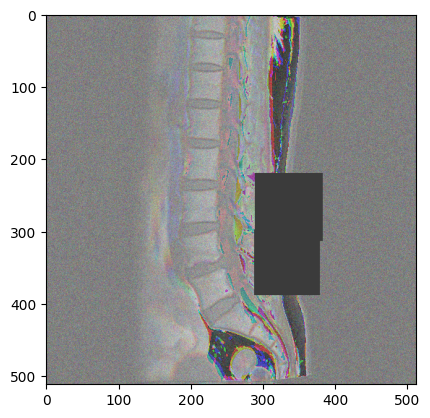

In [10]:
# generator_with_load_dataのテスト
for i, (x_batch, y_batch) in enumerate(
        generator_with_load_data(
            BATCH_SIZE,
            train_study_ids,
            'train_data',
            is_augmentation=True,
            is_shuffle=False,
            is_only_one_epoch=True
        )):
    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')

    # 画像の最大と最小値を表示
    print(f'x_batch max : {np.max(x_batch)}')
    print(f'x_batch min : {np.min(x_batch)}')

    # 型を表示
    print(f'x_batch dtype : {x_batch.dtype}')

    start_index = 5
    plt.imshow(x_batch[0, :, :, start_index:start_index+3])
    plt.show()

    if i==0:
        break

In [11]:
get_train_label(4003253)

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0.])

画像サイズ[GB] : 0.015380859375
データセット全体のデータ数は 30.377197265625


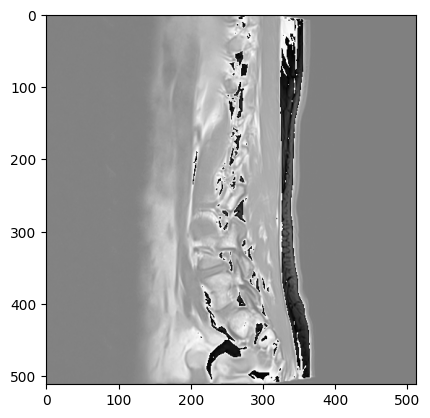

In [12]:
dicom_image_list = get_file_list(4003253, 'Sagittal T1')

input_image = get_dicom_input_data(4003253)
plt.imshow(input_image[:, :, 3], cmap='gray')
input_data_gb = input_image.nbytes / 1024 / 1024 / 1024
print(f"画像サイズ[GB] : {input_data_gb}")
print(f'データセット全体のデータ数は {input_data_gb * STUDY_NUM}')

In [13]:
def total_acc(y_true, y_pred):
    pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float64)
    flag = tf.dtypes.cast(tf.math.equal(y_true, pred), tf.float64)
    return tf.reduce_prod(flag, axis=-1)


def binary_acc(y_true, y_pred):
    pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float64)
    flag = tf.dtypes.cast(tf.math.equal(y_true, pred), tf.float64)
    return tf.reduce_mean(flag, axis=-1)

def log_loss_metrics(y_true, y_pred):
    # target を output の型にキャスト
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    epsilon_ = constant_op.constant(0.00001, y_pred.dtype)
    loss_weight = tf.constant(np.array([1, 2, 4] * 25), y_pred.dtype)

    # nan を防ぐためにクリップ
    y_pred = clip_ops.clip_by_value(y_pred, epsilon_, 0.99999)

    # output を (None, 25, 3) に変換
    y_pred = tf.reshape(y_pred, (-1, 25, 3))
    
    # 各行ごとにsoftmaxを適用
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # (75, ) に変換
    y_pred = tf.reshape(y_pred, (-1, 75))

    # 交差エントロピーの計算
    bce = y_true * math_ops.log(y_pred + epsilon_) * loss_weight
    bce += (1.0 - y_true) * math_ops.log(1.0 - y_pred + epsilon_)
    
    # 交差エントロピーの正規化
    bce_avg = K.mean(-bce, axis=-1)
    return bce_avg

def binary_crossentropy_balance(target, output):
    # target を output の型にキャスト
    target = tf.dtypes.cast(target, output.dtype)
    epsilon_ = constant_op.constant(0.00001, output.dtype)
    loss_weight = tf.constant(np.array([1, 2, 4] * 25), output.dtype)

    # nan を防ぐためにクリップ
    output = clip_ops.clip_by_value(output, epsilon_, 0.99999)

    # output を (None, 25, 3) に変換
    output = tf.reshape(output, (-1, 25, 3))
    
    # 各行ごとにsoftmaxを適用
    output = tf.nn.softmax(output, axis=-1)

    # (75, ) に変換
    output = tf.reshape(output, (-1, 75))


    # 交差エントロピーの計算
    bce = target * math_ops.log(output + epsilon_) * loss_weight
    bce += (1.0 - target) * math_ops.log(1.0 - output + epsilon_)

    bce_sum = -K.sum(bce, axis=-1)
    return bce_sum


def create_model():
    # カスタム入力層
    input_shape = (INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS)
    inputs = Input(shape=input_shape)

    # EfficientNetB7ベースモデル（トップ層なし）
    base_model = tf.keras.applications.EfficientNetV2M(
        include_top=False,
        weights=None,
        input_tensor=inputs,
        input_shape=(INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS),
        pooling='avg'  # グローバルプーリングを使用して特徴を抽出
    )

    # ベースモデルの出力
    x = base_model.output

    # 出力層（クラス数に応じて調整）
    outputs = Dense(N_CLASSES, activation='sigmoid')(x)

    # モデルの作成
    model = Model(inputs=inputs, outputs=outputs)

    # optimizer : Adam
    opt = tf.keras.optimizers.AdamW(learning_rate=Lr)

    # モデルのコンパイル
    model.compile(optimizer=opt,
                  loss=binary_crossentropy_balance,
                  metrics=[binary_acc, total_acc, log_loss_metrics])

    return model


model = create_model()

/home/toru/PycharmProjects/til/venv/lib/python3.10/site-packages/keras/src/applications/efficientnet_v2.py:911: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 63 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
2024-07-01 16:05:36.506355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 16:05:36.547620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 16:05:36.550341: I external/loc

In [14]:
from keras.src.callbacks import EarlyStopping


class CustomCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_val_accuracy = 1.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_log_loss_metrics = logs.get('val_log_loss_metrics')

        if val_log_loss_metrics is not None and val_log_loss_metrics < self.best_val_accuracy and val_log_loss_metrics < 0.8:
            self.best_val_accuracy = val_log_loss_metrics
            filepath = f'{self.filepath}_epoch{epoch + 1}_val_logloss_{val_log_loss_metrics:.4f}.keras'
            self.model.save(filepath, overwrite=True)
            print(f'Saved model to {filepath} with validation accuracy: {val_log_loss_metrics:.4f}')
        else:
            # 10 epoch ごとにモデルを保存
            if (epoch + 1) % 10 == 0:
                filepath = f'{self.filepath}_epoch{epoch + 1}_val_logloss_{val_log_loss_metrics:.4f}.keras'
                self.model.save(filepath, overwrite=True)
                print(f'Saved model to {filepath} with validation accuracy: {val_log_loss_metrics:.4f}')


# カスタムチェックポイントのコールバックを作成
custom_checkpoint = CustomCheckpoint(filepath='model_effi')
Ecall = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [15]:
# モデルの学習
history = model.fit(
    generator_with_load_data(BATCH_SIZE, train_study_ids, is_augmentation=True, is_shuffle=True,
                             file_name='train_data'),
                             steps_per_epoch=len(train_study_ids) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=generator_with_load_data(BATCH_SIZE, valid_study_ids, is_augmentation=False, is_shuffle=False,
                                             file_name='valid_data'),
    validation_steps=len(valid_study_ids) // BATCH_SIZE,
    callbacks=[custom_checkpoint, Ecall]
)

model.save(model_path)

Epoch 1/1000


I0000 00:00:1719817623.495260   30894 service.cc:145] XLA service 0x7335ac005120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719817623.495289   30894 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-07-01 16:07:06.475344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 16:07:14.171988: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   1/1580 ━━━━━━━━━━━━━━━━━━━━ 111:30:51 254s/step - binary_acc: 0.5467 - log_loss_metrics: 0.6380 - loss: 47.8516 - total_acc: 0.0000e+00

I0000 00:00:1719817816.747595   30894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 828/1580 ━━━━━━━━━━━━━━━━━━━━ 8:56 713ms/step - binary_acc: 0.6908 - log_loss_metrics: 0.7354 - loss: 55.1569 - total_acc: 0.0000e+00

In [ ]:
# lossとaccuracyのグラフを描画
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(history.history['binary_acc'], label='binary_acc')
plt.plot(history.history['val_binary_acc'], label='val_binary_acc')
plt.legend()
plt.title('binary_acc')
plt.show()

plt.plot(history.history['total_acc'], label='total_acc')
plt.plot(history.history['val_total_acc'], label='val_total_acc')
plt.legend()
plt.title('total_acc')
plt.show()


In [ ]:
# モデルの読み込み
loaded_model = tf.keras.models.load_model('model_effi_epoch10_val_logloss_0.6483.keras', custom_objects={
    'binary_crossentropy_balance': binary_crossentropy_balance,
    'binary_acc': binary_acc,
    'total_acc': total_acc,
    'log_loss_metrics': log_loss_metrics
})

In [ ]:
# Kaggle でのスコアを計算 (logloss)
from sklearn.metrics import log_loss

y_true = []
y_pred = []

for x_batch, y_batch in generator_with_load_data(BATCH_SIZE, test_study_ids, 'test_data', is_augmentation=False,
                                                 is_shuffle=False, is_only_one_epoch=True):
    y_true.extend(y_batch)

    y_pred.extend(loaded_model.predict(x_batch, verbose=3))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# weight を y_trueと同じ形状に変換
weights = np.array([1, 2, 4] * 25)
weights = np.tile(weights, (y_true.shape[0], 1))


In [ ]:
# y_pred を (None, 25, 3) に変換
y_pred = np.reshape(y_pred, (-1, 25, 3))

# 各行ごとにsoftmaxを適用
y_pred = tf.nn.softmax(y_pred, axis=-1)

# (75, ) に変換
y_pred = np.reshape(y_pred, (-1, 75))

# logloss を計算
logloss = log_loss(y_true.flatten(), y_pred.flatten(), sample_weight=weights.flatten(), normalize=True)
print(f'logloss : {logloss}')

# このモデルのスコアをファイル名にして保存
model_name = f'model_{logloss:.4f}.keras'
loaded_model.save(model_name)

In [ ]:
# 正答率を保存する
correct_rate = {}
for condition in CONDITIONS:
    for level in LEVELS:
        correct_rate[f'{condition}_{level}'] = 0

for i, (x_batch, y_batch) in enumerate(
        generator_with_load_data(
            BATCH_SIZE,
            test_study_ids,
            'test_data',
            is_augmentation=False,
            is_shuffle=False,
            is_only_one_epoch=True
        )):
    y_pred = loaded_model.predict(x_batch)
    print(f'batch {i + 1} : {y_pred.shape}')

    # 1バッチ分のデータを一つずつ取り出す
    for j in range(min(BATCH_SIZE, len(y_pred))):

        # (25, 3) に変換
        y_pred_reshaped = y_pred[j].reshape((N_LABELS, 3))
        y_true_reshaped = y_batch[j].reshape((N_LABELS, 3))

        # 0.5 以上の値を 1 に変換
        y_pred_reshaped = np.where(y_pred_reshaped >= 0.5, 1, 0)

        # 最も大きい値を取得
        y_pred_argmax = np.argmax(y_pred_reshaped, axis=1)
        y_true_argmax = np.argmax(y_true_reshaped, axis=1)

        # print(f'y_pred_argmax : {y_pred_argmax}')
        # print(f'y_true_argmax : {y_true_argmax}')
        # 
        # print(f'y_true_argmax : {y_true_argmax.shape}')

        # 書くレベルと条件に対して正解しているかどうかを確認
        for i, cond in enumerate(CONDITIONS):
            for j, level in enumerate(LEVELS):
                index = i * len(LEVELS) + j
                if y_pred_argmax[index] == y_true_argmax[index]:
                    correct_rate[f'{cond}_{level}'] += 1

# 正答率を計算, condition ごとに計算, levelはまとめる
condition_rate_list = []
for condition in CONDITIONS:
    rate = 0
    for level in LEVELS:
        rate += correct_rate[f'{condition}_{level}']
    condition_rate_list.append(rate / (len(test_study_ids) * len(LEVELS)))

# levelごとの正答率を計算
level_rate_list = []
for level in LEVELS:
    rate = 0
    for condition in CONDITIONS:
        rate += correct_rate[f'{condition}_{level}']
    level_rate_list.append(rate / (len(test_study_ids) * len(CONDITIONS)))

# 棒グラフで表示
plt.figure(figsize=(20, 10))
plt.bar(CONDITIONS, condition_rate_list)

plt.figure(figsize=(20, 10))
plt.bar(LEVELS, level_rate_list)
